
### . Train pseudoinverse solution + CNN denoising
This tutorial shows how to train PinvNet with a CNN denoiser for
reconstruction of linear measurements 


#### Load a batch of images



Shape of input images: torch.Size([7, 1, 64, 64])


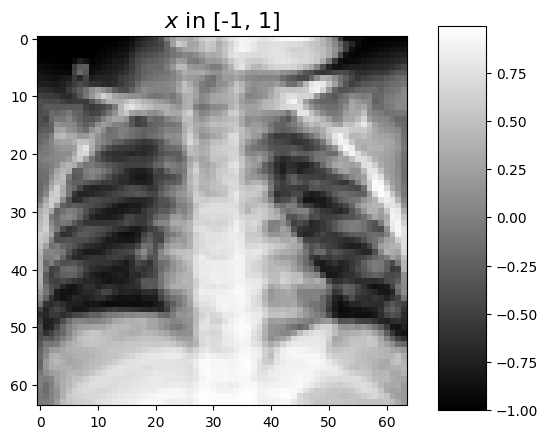

In [1]:
import os
from spyrit.misc.statistics import transform_gray_norm
import torchvision
import torch
from spyrit.misc.disp import imagesc

h = 64  # image size hxh
i = 1  # Image index (modify to change the image)
spyritPath = os.getcwd()
imgs_path = os.path.join(spyritPath, "../images")

transform = transform_gray_norm(img_size=h)
dataset = torchvision.datasets.ImageFolder(root=imgs_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=7)

x, _ = next(iter(dataloader))
print(f"Shape of input images: {x.shape}")

# Select image
x = x[i-1 : i , :, :, :]
x = x.detach().clone()
b, c, h, w = x.shape

# plot
x_plot = x.view(-1, h, h).cpu().numpy()
imagesc(x_plot[0, :, :], r"$x$ in [-1, 1]")

In [2]:
#Loading data
from spyrit.misc.statistics import data_loaders_stl10
from pathlib import Path

# Parameters
h = 64  
data_root = Path("./data")  
batch_size = 512

# Dataloader for STL-10 dataset
mode_run = False
if mode_run:
    dataloaders = data_loaders_stl10(
        data_root,
        img_size=h,
        batch_size=batch_size,
        seed=7,
        shuffle=True,
        download=True,
    )

#### e a Hadamard matrix 
* Taking only low frequency sample



In [3]:
from spyrit.misc.walsh_hadamard import walsh2_matrix
import numpy as np
import math
from spyrit.misc.disp import imagesc
from spyrit.misc.sampling import Permutation_Matrix

und = 4  # undersampling factor
M = h**2 // und  # number of measurements (undersampling factor = 4)

F = walsh2_matrix(h)
F = np.where(F > 0, F, 0)

Sampling_map = np.ones((h, h))
M_xy = math.ceil(M**0.5)
Sampling_map[:, M_xy:] = 0
Sampling_map[M_xy:, :] = 0

# imagesc(Sampling_map, 'low-frequency sampling map')

Perm = Permutation_Matrix(Sampling_map)
F = Perm @ F
H = F[:M, :]

print(f"Shape of the measurement matrix: {H.shape}")

Shape of the measurement matrix: (1024, 4096)


In [4]:
# Initializinz preprocessing  and noiseless case
from spyrit.core.meas import Linear
from spyrit.core.noise import NoNoise
from spyrit.core.prep import DirectPoisson

meas_op = Linear(H, pinv=True)
noise = NoNoise(meas_op)
N0 = 1.0  # Mean maximum total number of photons
prep = DirectPoisson(N0, meas_op)  # "Undo" the NoNoise operator

#### PinvNet Network
* reconstructs an image by computing the pseudoinverse solution and applies a nonlinear
network denoiser,  CNN  denoiser




In [5]:
import torch
from spyrit.core.nnet import ConvNet
from spyrit.core.recon import PinvNet

denoiser = ConvNet()
model = PinvNet(noise, prep, denoi=denoiser)
## checking if GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

#### Define a Loss function optimizer and scheduler
* We use the Mean Square Error (MSE) loss function, weigh decay
loss and the Adam optimizer. The scheduler decreases the learning rate
by a factor of :attr:`gamma` every :attr:`step_size` epochs.
* Adam computes individual adaptive learning rates for different parameters.


In [6]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from spyrit.core.train import save_net, Weight_Decay_Loss

# Parameters
lr = 1e-3
step_size = 10
gamma = 0.5

loss = nn.MSELoss()
criterion = Weight_Decay_Loss(loss)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#### Train the network
we use train model function.
* It iterates through the dataloader, feeds the inputs to the
network and optimizes the solution (by computing the loss and its gradients and
updating the network weights at each iteration). 
*In addition, it computes
the loss and desired metrics on the training and validation sets 





In [7]:
# We train for one epoch only to check that everything works fine.

from spyrit.core.train import train_model
from datetime import datetime

# Parameters
model_root = Path("./model")  # path to model saving files
num_epochs = 5  # number of training epochs (num_epochs = 30)
checkpoint_interval = 2  # interval between saving model checkpoints
tb_freq = (
    50  # interval between logging to Tensorboard (iterations through the dataloader)
)

# Path for Tensorboard experiment tracking logs
name_run = "stdl10_hadampos"
now = datetime.now().strftime("%Y-%m-%d_%H-%M")
tb_path = f"runs/runs_{name_run}_n{int(N0)}_m{M}/{now}"

# Train the network
if mode_run:
    model, train_info = train_model(
        model,
        criterion,
        optimizer,
        scheduler,
        dataloaders,
        device,
        model_root,
        num_epochs=num_epochs,
        disp=True,
        do_checkpoint=checkpoint_interval,
        tb_path=tb_path,
        tb_freq=tb_freq,
    )
else:
    train_info = {}

#### Save the network and training history
We save the model so that it can later be utilized. We save the network's
architecture, the training parameters and the training history.





In [8]:
from spyrit.core.train import save_net

# Training parameters
train_type = "N0_{:g}".format(N0)
arch = "pinv-net"
denoi = "cnn"
data = "stl10"
reg = 1e-7  # Default value
suffix = "N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}".format(
    h, M, num_epochs, lr, step_size, gamma, batch_size
)
title = model_root / f"{arch}_{denoi}_{data}_{train_type}_{suffix}"
print(title)

Path(model_root).mkdir(parents=True, exist_ok=True)

if checkpoint_interval:
    Path(title).mkdir(parents=True, exist_ok=True)

save_net(title, model)

# Save training history
import pickle

if mode_run:
    from spyrit.core.train import Train_par

    params = Train_par(batch_size, lr, h, reg=reg)
    params.set_loss(train_info)

    train_path = model_root / f"TRAIN_{arch}_{denoi}_{data}_{train_type}_{suffix}.pkl"

    with open(train_path, "wb") as param_file:
        pickle.dump(params, param_file)
    torch.cuda.empty_cache()
else:
    # Download training history
    import gdown

    train_path = os.path.join(
        model_root,
        "TRAIN_pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07.pkl",
    )
    url_train = "https://drive.google.com/file/d/13KIbSEigHBZ8ub_JxMUqwRDMHklnFz8A/view?usp=drive_link"
    gdown.download(url_train, train_path, quiet=False, fuzzy=True)

    with open(train_path, "rb") as param_file:
        params = pickle.load(param_file)
    train_info["train"] = params.train_loss
    train_info["val"] = params.val_loss

model\pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_5_lr_0.001_sss_10_sdr_0.5_bs_512
model\pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_5_lr_0.001_sss_10_sdr_0.5_bs_512.pth
Model Saved


Downloading...
From: https://drive.google.com/uc?id=13KIbSEigHBZ8ub_JxMUqwRDMHklnFz8A
To: c:\Users\RAmsh\OneDrive\Desktop\gjbhjbkhb\spyrit-master1 - Copy\spyrit\tutorial\model\TRAIN_pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07.pkl
100%|██████████| 714/714 [00:00<?, ?B/s] 


We plot the training loss and validation loss



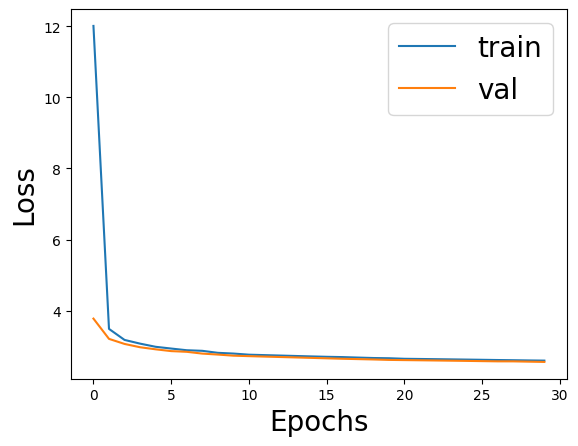

In [9]:
# plot
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_info["train"], label="train")
plt.plot(train_info["val"], label="val")
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend(fontsize=20)